In [ ]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

from scipy.sparse import diags
from scipy.sparse import linalg


class Simulation:
    """
    A simulation contains all variables to simulate a 1D running wave. This class has the possibility to make an
    animation or to run a simulation without making an simulation.
    """
    
    def __init__(self,dx,dt,tSteps,xBegin,xEnd,PotVector,beginPos):
        """
        Initializes the simulation with the needed constants. dx is the stepsize of the xVector, which begins at 
        xBegin and ends at xEnd. dt is the timestep. The number of timesteps is tSteps. PotVector stands for the 
        potential in which the wave moves and beginPos the startingpoint of the wave.

        :param dx: Stepsize of xVector
        :param dt: Timestep
        :param tSteps: Number of timesteps
        :param xBegin: Begin point of the xVector  
        :param xEnd: End point of the xVector
        :param PotVector: Vector with the 1D potential
        """
        self.dx = dx
        self.dt = dt
        self.tEnd = tEnd
        self.xBegin = xBegin
        self.xEnd = xEnd
        self.N = int(xEnd/dx)
        self.PotVector = PotVector
        self.xVector = np.linspace(xBegin,xEnd,N)
        self.func = self.WaveFunctionStart(beginPos)
    
    def WaveFunctionStart(self,beginPos):
        """
        Creates the begin waveFunction. This is a gausian curve with its center at beginPos.
        
        :param beginPos: the position of the middle of the gaussian curve
        :returns func: the created wavefunction
        """
        f = np.exp(-40*(self.xVector-beginPos)**2)
        func = f/np.sqrt(np.trapz(f**2,self.xVector))
        func = func*np.exp(1j*0.2/self.dx*self.xVector)
        return func
    
    def run(self):
        """
        Runs a 1D moving wave simulation. Creates a matrix with the probabillity density function for different
        timesteps. 
        
        :returns fArray: Matrix with probabillity density function for different timesteps.
        """
        N = self.N
        diagnull = -2*np.ones(N)
        diagone = np.ones(N-1)
        diagonals = [diagone, diagnull, diagone]

        #matrix with kinetic energy values for nearest neighbour
        Hmatrix = diags(diagonals,[-1,0,1]).toarray()

        #matrix with potential values 
        Vmatrix = diags([self.PotVector],[0]).toarray()

        Hamiltonian = Hmatrix/self.dx**2 - Vmatrix

        Pade = np.eye(N) + 1j*Hamiltonian*self.dt/2
        Padeconj = np.eye(N) - 1j*Hamiltonian*self.dt/2
        Padeinv = sp.linalg.inv(Padeconj)
        
        #memory allocation for fArray with all wave function values for all times
        fArray = np.zeros((N,int(tEnd)),dtype=complex)

        #initializing 
        fArray[:,0] = self.func
        
        for t in range(1,self.tEnd):
            #calculation of time evolution with use of Pade approximation
            fArray[:,t] = np.dot(Pade,np.dot(Padeinv,fArray[:,t-1]))
            
        return fArray
    
    def animations(self):
        """
        Creates an animation of the movement of the 1D wave  
        
        :returns fArray: Matrix with probabillity density function for different timesteps.
        """
        fArray = self.run()
        xVector = self.xVector
        PotVector = self.PotVector
        
        plt.close('all')
        fig = plt.figure()
        ax = plt.axes(xlim=(self.xBegin, self.xEnd), ylim=(0, 10))
        line1, = ax.plot([], [], lw=2)
        line2, = ax.plot([], [], 'r')
        lines = [line1, line2]

        # initialization function: plot the background of each frame
        def init():
            for line in lines:
                line.set_data([], [])
            return lines,

        # animation function.  This is called sequentially
        def animate(i):
            lines[0].set_data(xVector, np.absolute(fArray[:,i])**2)
            lines[1].set_data(xVector, PotVector)
            return lines

        # call the animator.  blit=True means only re-draw the parts that have changed.
        anim = animation.FuncAnimation(fig, animate, frames=tEnd, interval=10, blit=True)
        return anim, fArray

In [ ]:
#Simulation execution and parameter specification
dx = 0.0005 #stepsize in spatial discretization
dt = 0.0005 #timestep
tEnd = 20000
xEnd = 3
xBegin = 0
N = int(xEnd/dx)#number of discretization points


    #potential barrier
beginPos = 0.4
PotVector = np.zeros(N)
PotVector[int(3/8*N):int(4/8*N)] = 1500

    #no potential for checking code
zeroPotential = np.zeros(N)
#Creating analytical data to compare with
xVector = np.linspace(xBegin,xEnd,N)
tVector = np.linspace(1,tEnd,tEnd)*dt
f0 = np.exp(-40*(xVector-beginPos)**2)
f0 = f0/np.sqrt(np.trapz(f0**2,xVector))
ft = f0*np.exp(1j*0.2/dx*np.tensordot(tVector,xVector, axes = 0))

    #square well
beginPos2 = 1.5
PotVector2 = 20000*np.ones(N)
PotVector2[int(2/8*N):int(6/8*N)] = 0


#func = WaveFunctionStart(xVector,BeginPos,dx)

sim = Simulation(dx,dt,tEnd,xBegin,xEnd,PotVector,beginPos)
#fArray = sim.run()

anim, fArray = sim.animations()

HTML(anim.to_html5_video())

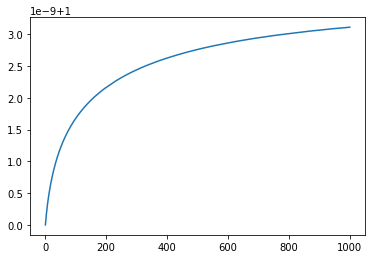

In [37]:
#this figure plots the change in wave function area
#to check for errors in the program
means = np.trapz(np.absolute(fArray)**2,xVector,axis=0)
plt.close('all')
plt.plot(range(1,tEnd+1),means)
#plot of potential
plt.show()
#when the square well potential is used, the errors in the wave function become significantly larger.